In [1]:
# compute_deltaseaice_longterm_means
#
# Steven Cavallo
# December 2024
###########################
# imports
###########################
import matplotlib.pyplot as plt
import numpy as np
import sys, imp
import pylab
import datetime as dt
import os, datetime
import csv
from scipy.fftpack import fft
from scipy.signal import blackman, butter, lfilter, filtfilt, freqz, periodogram
import pandas as pd

import weather_modules as wm
import utilities_modules as um
from mstats import *


/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_13467/3595468087.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, imp


In [2]:
fpath = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/N_seaice_extent_daily_v3.0.csv'
output_path1 = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_daily_dextent_int_longtermmean_errorbars_1989_2018_3d_noshift.dat'
output_path2 = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_monthly_dextent_int_longtermmean_errorbars_1989_2018_3d_noshift.dat'
plot_variable = 'dextent_int' # 'extent','dextent', dextent_int, or dextent_diff
filter_option = 'none' # options are 'nearby', butterworth', and 'none'
number_days_dextent = 3
write_climatology = 'True'
plot_climatology = 'True'
years_climo = [1989,2018]
compute_errorbars = True
errorbar_percentiles = [100,0] # [100,0] will compute the record daily minima and maxima 
timeinc = 24 # time between data
label_fontsize = 16
imagedir = '/Users/scavallo/Documents/scripts/python_scripts/images/'

In [3]:
file = open(fpath, 'r')
data = np.loadtxt(file,skiprows=2, delimiter=',',usecols=(0,1,2,3))
years = data[:,0].astype(int) #e.g., 1981
months = data[:,1].astype(int) #e.g., 01
days=data[:,2].astype(int) #e.g., 01
extents = data[:,3] #e.g., 11.345 [10^6km^2]    
    
#convert individual yr,month,day to time values
nVals = len(extents)
print(nVals)
timeList = [dt.datetime(years[i],months[i],days[i]) for i in range(nVals)]; timeList = np.array(timeList)
  
#interpolate to uniform time grid ("daily" values early on are every 2 days)
tStart = timeList[0]; tEnd = timeList[-1]
nDays = (tEnd-tStart).total_seconds()/(24*3600); nDays = int(nDays)
print('{0} days between {1} {2}'.format(nDays, tStart, tEnd))
times = [tStart+ dt.timedelta(days=i) for i in range(0, nDays)]; times = np.array(times)
  
dTime = [(a-timeList[0]).total_seconds() for a in timeList]
dTimeResample = [(a-timeList[0]).total_seconds() for a in times]
extents = np.interp(dTimeResample, dTime, extents)    
    
del years, months, days
years = [i.year for i in times]
months = [i.month for i in times]
days = [i.day for i in times]
    
years = np.array(years)
months = np.array(months)
days = np.array(days)


14853
16503 days between 1978-10-26 00:00:00 2024-01-01 00:00:00


In [4]:
year_range = [1989,2022]

ndays=number_days_dextent 
dextent = np.zeros_like(extents).astype('f')

if ndays==3:
    dextent[(ndays-2):-(ndays-1)] = extents[ndays:] - extents[0:-ndays] 
    dextent[0:(ndays-2)] = dextent[ndays-2]             # fills first values
    dextent[-(ndays-2):] = dextent[-(ndays-1)]
elif ndays==2:
    dextent[(ndays-1):-(ndays-1)] = extents[ndays:] - extents[0:-ndays] 
    dextent[0] = dextent[1]             # fills first values
    dextent[-1] = dextent[-2]
else:
    dextent[0:-1] = extents[1:] - extents[0:-1] 
    dextent[-1] = dextent[0]


[inds]= np.where( (years>=year_range[0]) & (years<=year_range[-1]) & ((months !=2 ) | (days !=29 )))

timefocus = times[inds]
yearfocus = years[inds]
monthfocus = months[inds]
dayfocus = days[inds]
extentfocus = extents[inds]


if plot_variable == 'dextent_int':
    dextent_int = dextent[inds]
    
if plot_variable == 'dextent_diff':
    dextent_int = dextent[inds]

if plot_variable == 'extent':
    datain = extentfocus
if plot_variable == 'dextent':
    datain = dextent
if plot_variable == 'dextent_int':
    datain = dextent_int
if plot_variable == 'dextent_diff':
    datain = dextent_int 

z0 = np.zeros_like(extentfocus).astype('f')


extent_filt = extentfocus
dextent_filt = datain #dextent


In [5]:
#if 1 == 1:
if filter_option == 'butterworth':
    #butter_order = 3
    butter_order = 12
    sample_days = 1.0 # days
    lowcut_days = 18.0 # days

    sample_rate = sample_days*24.0*3600.0 # convert to seconds
    lowcut = lowcut_days*24.0*3600.0 # convert to seconds
 
    sample_freq = 1.0/sample_rate
    lowcut_freq = 1.0/lowcut # convert to Hz
    nyq = 0.5*sample_freq

    lowcut = lowcut_freq/nyq

    b, a = butter(butter_order,lowcut,btype='highpass')
    datain_unfiltered = datain
    datain_mean = np.nanmean(datain)
    data_bw = filtfilt(b,a,datain)
    if ( (plot_variable == 'dextent_int') or (plot_variable == 'dextent_diff' ) ):
        extent_filt = extentfocus
        dextent_filt = data_bw
    
        extent_filt = np.zeros_like(extentfocus).astype('f')
        extent_filt[0] = extentfocus[180]
        for ii in range(len(extent_filt)-1):
            extent_filt[ii+1] = extent_filt[ii] + dextent_filt[ii]


In [6]:
monthscheck = np.array(monthfocus)
dayscheck = np.array(dayfocus)
yearscheck = np.array(yearfocus)
timescheck = np.array(timefocus)

day_climo = []
month_climo = []
extent_climo = []
dextent_climo = []
dextent_climo_ll = []
dextent_climo_ul = []



ul = errorbar_percentiles[0]
ll = errorbar_percentiles[1]

start_date = '1985010100' # This should be January 1 of any year
end_date = '1985123100' # This should be December 31 of that same year above
datenow = start_date
while (datenow<=end_date):
    
    yyyy = int(datenow[0:4])
    mm = int(datenow[4:6])
    dd = int(datenow[6:8])
    hh = datenow[8:10]
       
    #print todaysinds   
    a = pd.Timestamp(int(yyyy), int(mm), int(dd))
    month_end_check = a.is_month_end
    day_start_check = int(dd)
    if ( (month_end_check == False) and (day_start_check != 1) and (day_start_check != 2) ): 
        todaysinds = np.where( (monthscheck==mm) & (dayscheck==dd) & (yearfocus>=years_climo[0]) & (yearfocus<=years_climo[1]) )

        month_climo.append(mm)
        day_climo.append(dd)
        extent_climo.append(np.nanmean(extent_filt[todaysinds]))
        dextent_climo.append(np.nanmean(dextent_filt[todaysinds])) 
        dextent_climo_ll.append(np.percentile(dextent_filt[todaysinds], ll))
        dextent_climo_ul.append(np.percentile(dextent_filt[todaysinds], ul))

    else:
        month_climo.append(mm)
        day_climo.append(dd)
        extent_climo.append(float('NaN'))
        dextent_climo.append(float('NaN'))
        dextent_climo_ll.append(float('NaN'))
        dextent_climo_ul.append(float('NaN'))
    
    datenow = um.advance_time(datenow,timeinc)

extent_climo_monthly = []
dextent_climo_monthly = []
dextent_climo_monthly_ll_0 = []
dextent_climo_monthly_ul_100 = []
dextent_climo_monthly_ll_1 = []
dextent_climo_monthly_ul_99 = []
dextent_climo_monthly_ll_5 = []
dextent_climo_monthly_ul_95 = []
dextent_climo_monthly_ll_10 = []
dextent_climo_monthly_ul_90 = []
for tt in range(1,13):
    todaysinds = np.where(monthscheck==tt)
    #if tt==12:
    #    mstats(dextent_filt[todaysinds])
    extent_climo_monthly.append(np.nanmean(extent_filt[todaysinds]))
    dextent_climo_monthly.append(np.nanmean(dextent_filt[todaysinds]))
    dextent_climo_monthly_ll_0.append(np.percentile(dextent_filt[todaysinds], 0))
    dextent_climo_monthly_ul_100.append(np.percentile(dextent_filt[todaysinds], 100))  
    dextent_climo_monthly_ll_1.append(np.percentile(dextent_filt[todaysinds], 1))
    dextent_climo_monthly_ul_99.append(np.percentile(dextent_filt[todaysinds], 99))  
    dextent_climo_monthly_ll_5.append(np.percentile(dextent_filt[todaysinds], 5))
    dextent_climo_monthly_ul_95.append(np.percentile(dextent_filt[todaysinds], 95))  
    dextent_climo_monthly_ll_10.append(np.percentile(dextent_filt[todaysinds], 10))
    dextent_climo_monthly_ul_90.append(np.percentile(dextent_filt[todaysinds], 90)) 
dextent_climo_monthly_ll_0

[-0.3149999976158142,
 -0.35199999809265137,
 -0.44600000977516174,
 -0.4959999918937683,
 -0.44699999690055847,
 -0.6759999990463257,
 -0.7590000033378601,
 -0.5440000295639038,
 -0.2800000011920929,
 -0.04899999871850014,
 -0.2199999988079071,
 -0.2290000021457672]

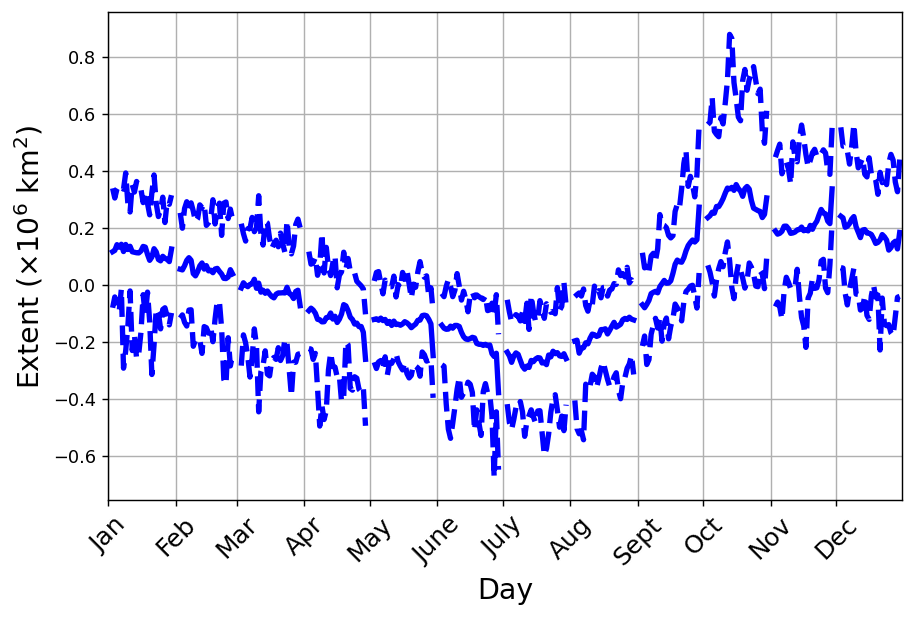

In [7]:
extent_climo_array = np.array(extent_climo)
dextent_climo_array = np.array(dextent_climo)
month_climo_array = np.array(month_climo)
day_climo_array = np.array(day_climo)
dayinds = np.where( (day_climo_array==1) )


if plot_climatology == 'True':

    t = np.arange(0,len(extent_climo_array),1)
    tmonths = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

    golden = (pylab.sqrt(5)+1.)/2.
    figprops = dict(figsize=(8., 8./ golden ), dpi=128)    # Figure properties for single and stacked plots
    adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2)

    fig = pylab.figure(**figprops)   # New figure
    ax1 = fig.add_subplot(1, 1, 1)

    p1, = ax1.plot(t,dextent_climo_array,'b',linewidth=3.0,label='dExtent')
    #p2, = ax1.plot(t,dextent_climo_bw_array,'r',linewidth=3.0,label='dExtent (butterworth)')
    #p2, = ax1.plot(t,dextent_int_test,'r',linewidth=3.0,label='dExtent test')
    #p3, = ax1.plot(t,z0,'k',linewidth=2.0)

    p2, = ax1.plot(t,dextent_climo_ll,'b--',linewidth=3.0)
    p3, = ax1.plot(t,dextent_climo_ul,'b--',linewidth=3.0)    

    ax1.grid(True, linestyle='-')
    ax1.set_ylabel(r'Extent ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
    ax1.set_xlabel('Day',fontsize=label_fontsize)

    #ax1.set_ylim(yticks1[0],yticks1[-1])
    #ax1.set_yticks(yticks1)
    
    ax1.set_xticks(t[dayinds])
    #ax1.set_xticklabels(month_climo_array[dayinds],rotation=90,fontsize=14)
    ax1.set_xticklabels(tmonths,rotation=45,fontsize=14)

    #xlims = ax1.get_xlim()
    #if ( np.size(dayfocus) < 367) :
    ax1.set_xlim(0,np.max(t))

    #legend = ax1.legend(loc='upper right', shadow=True)
    #save_name = imagedir + 'sea_ice_extent_noseasonal' + '.png'
    save_name = imagedir + 'sea_ice_extent_raw' + '.png'
    #plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [9]:
if write_climatology == 'True':
    outfile1 = open(output_path1,'w')
    wcount = 0
    if compute_errorbars == False:
        for ii in range(0,len(extent_climo)):
            print(extent_climo[ii])
            outfile1.write('%d %d %7.4f %7.4f\n' % (month_climo_array[ii], day_climo_array[ii], extent_climo[ii], dextent_climo[ii]))
            #outfile.write('%d %d %7.4f %7.4f\n' % (month_climo_array[ii], day_climo_array[ii], extent_climo[ii], dextent_climo))
    else:
        for ii in range(0,len(extent_climo)):
            print(extent_climo[ii])
            outfile1.write('%d %d %7.4f %7.4f %7.4f %7.4f\n' % (month_climo_array[ii], day_climo_array[ii], extent_climo[ii], dextent_climo[ii], dextent_climo_ll[ii], dextent_climo_ul[ii])) 
    
    outfile2 = open(output_path2,'w')
    wcount = 0
    if compute_errorbars == False :
        for ii in range(0,12):
            print(extent_climo_monthly[ii])
            outfile2.write('%d %7.4f %7.4f\n' % (ii+1,extent_climo_monthly[ii], dextent_climo_monthly[ii]))
            #outfile.write('%d %d %7.4f %7.4f\n' % (month_climo_array[ii], day_climo_array[ii], extent_climo[ii], dextent_climo))
    else:
        for ii in range(0,12):
            print(extent_climo_monthly[ii])
            outfile2.write('%d %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f\n' % (ii+1, extent_climo_monthly[ii], dextent_climo_monthly[ii], dextent_climo_monthly_ll_0[ii], dextent_climo_monthly_ul_100[ii], dextent_climo_monthly_ll_1[ii], dextent_climo_monthly_ul_99[ii], dextent_climo_monthly_ll_5[ii], dextent_climo_monthly_ul_95[ii], dextent_climo_monthly_ll_10[ii], dextent_climo_monthly_ul_90[ii]))         

nan
nan
13.540933333333335
13.582833333333333
13.62396666666667
13.661133333333332
13.723233333333333
13.755333333333333
13.802899999999998
13.839500000000003
13.896333333333331
13.926233333333334
13.974233333333334
14.011766666666666
14.040066666666666
14.086166666666665
14.12323333333333
14.158266666666666
14.220366666666669
14.255133333333333
14.264733333333334
14.305766666666667
14.35206666666667
14.390999999999998
14.420733333333333
14.440500000000002
14.4746
14.5202
14.533033333333332
14.563400000000001
nan
nan
nan
14.708599999999999
14.719166666666663
14.745899999999999
14.760399999999999
14.785766666666667
14.831066666666665
14.855166666666664
14.871333333333332
14.869966666666665
14.886133333333333
14.917133333333332
14.936133333333334
14.9623
14.9718
15.002966666666671
15.010733333333336
15.022666666666668
15.045066666666665
15.065766666666663
15.0798
15.091666666666667
15.103166666666665
15.102
15.113166666666668
15.130133333333331
nan
nan
nan
15.155033333333332
15.143700000